In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [42]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import SCORERS

In [3]:
df = pd.read_json('data/data.json')

In [4]:
# create binary labels for fraud and not fraud
fraud_idx = df[(df.acct_type=='fraudster_event')| (df.acct_type=='fraudster')|(df.acct_type=='fraudster_att')].index
# create label column
df['label'] = 0
df['label'].iloc[list(fraud_idx)]=1 # changes fraud labels to 1

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 45 columns):
acct_type             14337 non-null object
approx_payout_date    14337 non-null int64
body_length           14337 non-null int64
channels              14337 non-null int64
country               14256 non-null object
currency              14337 non-null object
delivery_method       14321 non-null float64
description           14337 non-null object
email_domain          14337 non-null object
event_created         14337 non-null int64
event_end             14337 non-null int64
event_published       14238 non-null float64
event_start           14337 non-null int64
fb_published          14337 non-null int64
gts                   14337 non-null float64
has_analytics         14337 non-null int64
has_header            8928 non-null float64
has_logo              14337 non-null int64
listed                14337 non-null object
name                  14337 non-null object
name_length      

In [6]:
df.country.unique()

array(['US', 'IE', 'FR', 'CA', 'GB', '', 'AU', 'ES', 'NL', 'DE', 'VN',
       'MY', 'NZ', 'PK', 'MA', 'AR', 'MX', 'CH', None, 'SG', 'TH', 'BE',
       'PH', 'A1', 'CI', 'AT', 'ID', 'PS', 'PT', 'TR', 'NI', 'KE', 'IT',
       'HU', 'RS', 'RO', 'NG', 'CZ', 'PR', 'AE', 'BS', 'KH', 'JM', 'IN',
       'NA', 'FI', 'HR', 'BG', 'VI', 'TJ', 'GH', 'PE', 'QA', 'SI', 'GR',
       'BB', 'CM', 'IS', 'SE', 'RU', 'DZ', 'VE', 'UY', 'ZA', 'IM', 'LB',
       'CR', 'IL', 'CN', 'DK', 'CO', 'EC', 'JE'], dtype=object)

In [12]:
def percent_fraud(code, lst):
    fraud = len(df[(df.country == code) & (df.label==1)])
    _all = len(df[df.country==code])
    if _all != 0 and (fraud/_all) >= 0.90:
        lst.append(code)

not_safe = []
for country in df.country.unique():
    percent_fraud(country, not_safe)

In [13]:
df['country_cat'] = 0

df['country_cat'][df.country.isin(not_safe)] = 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df.country_cat.value_counts()

0    14142
1      195
Name: country_cat, dtype: int64

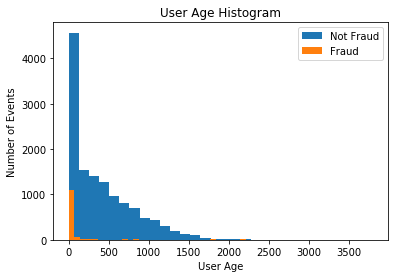

In [16]:
plt.hist(df[df.label==0].user_age.values, bins=30, label='Not Fraud')
plt.hist(df[df.label==1].user_age.values, bins=30, label='Fraud')
plt.xlabel('User Age')
plt.ylabel('Number of Events')
plt.title('User Age Histogram')
plt.legend()
plt.show()

In [17]:
# event created and event end
df['time_until_end']=df.event_end-df.event_created
df.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,label,country_cat,time_until_end
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,1,0,2890694
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC,0,0,2455330
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA,0,0,4649844
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,3,,None,NaN,NaN,None,None,0,0,27852830
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA,0,0,5474134


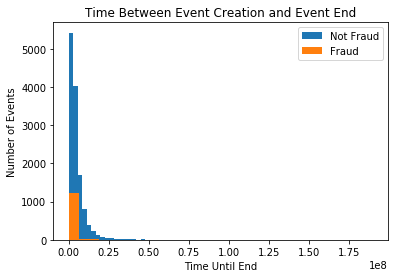

In [18]:
plt.hist(df[df.label==0].time_until_end.values, bins=30, label='Not Fraud')
plt.hist(df[df.label==1].time_until_end.values, bins=30, label='Fraud')
plt.xlabel('Time Until End')
plt.ylabel('Number of Events')
plt.title('Time Between Event Creation and Event End')
plt.legend()
plt.show()

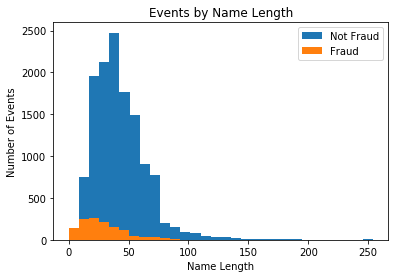

In [19]:
plt.hist(df[df.label==0].name_length.values, bins=30, label='Not Fraud')
plt.hist(df[df.label==1].name_length.values, bins=30, label='Fraud')
plt.xlabel('Name Length')
plt.ylabel('Number of Events')
plt.title('Events by Name Length')
plt.legend()
plt.show()

In [20]:
df['upper'] = df.name.apply(lambda x: x.isupper())

df.upper = df.upper.astype(int)

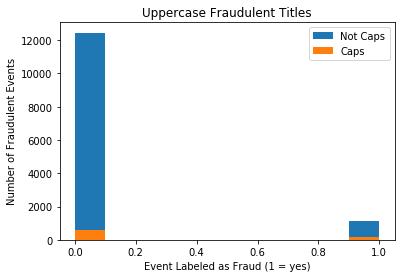

In [21]:
plt.hist(df[df.upper==0].label.values, label='Not Caps')
plt.hist(df[df.upper==1].label.values, label='Caps')
plt.xlabel('Event Labeled as Fraud (1 = yes)')
plt.ylabel('Number of Fraudulent Events')
plt.title('Uppercase Fraudulent Titles')
plt.legend()
plt.show()

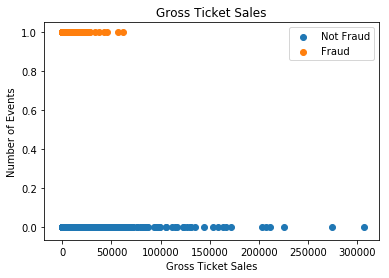

In [22]:
plt.scatter(df[df.label==0].gts.values, df[df.label==0].label.values, label='Not Fraud')
plt.scatter(df[df.label==1].gts.values, df[df.label==1].label.values, label='Fraud')
plt.xlabel('Gross Ticket Sales')
plt.ylabel('Number of Events')
plt.title('Gross Ticket Sales')
plt.legend()
plt.show()

This just shows survivor bias, fraudulent events tend to be caught before making too much money

In [23]:
X = df[['user_age', 'country_cat', 'upper', 'time_until_end', 'num_order', 'body_length']].values
y = df.label.values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, auc


def roc_plot(y_test, y_scores, g_params="ROC"):    
    '''
    plots an roc curve
    Input:
        y_test:     labeled y_test values
        y_scores:   classifier.fit(X_train, y_train).decision_function(X_test)
        g_params:   str. describe model output
    '''
    
    n_classes = 1
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    #print(fpr, tpr)
    roc_auc = auc(fpr, tpr)
    #print(roc_auc)

    plt.figure() 
    lw = 2 
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('ROC: Random Forest:  {} '.format(g_params)) 
    plt.legend(loc="lower right") 
    plt.show()

In [30]:
model = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=100)

In [51]:
cv_score = cross_val_score(model, X, y, n_jobs=-1, cv=5)

print("Cross Validated Scores: {}".format(cv_score)) 
print("Mean: {:0.3f}".format( cv_score.mean()))

Cross Validated Scores: [0.9665272  0.97105997 0.96827057 0.96267876 0.965806  ]
Mean: 0.967


In [52]:
cv_results = cross_validate(model, X, y, scoring='roc_auc', cv=5)

print("Cross Validated Roc Auc: {}".format(cv_results['test_score']))
print("Mean: {:0.3f}".format( cv_results['test_score'].mean()))

Cross Validated Roc Auc: [0.97014714 0.95472533 0.9658481  0.97340007 0.94983236]
Mean: 0.963


In [53]:
model.fit(X_train, y_train)

y_scores = model.predict_proba(X_test)[:,1]

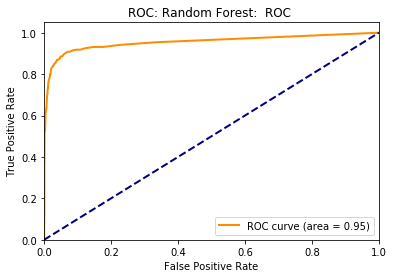

In [54]:
roc_plot(y_test, y_scores)

## Use time between event, name length, country, whether or not the title is all caps as features